# Dimension Reduction


This notebook provides a comprehensive guide on implementing Dimension Reduction using scikit-learn libraries.

By: Bryce Li, NUS

## PCA example with Iris Data-set

In [1]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

from sklearn import datasets, decomposition

np.random.seed(5)

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [3]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

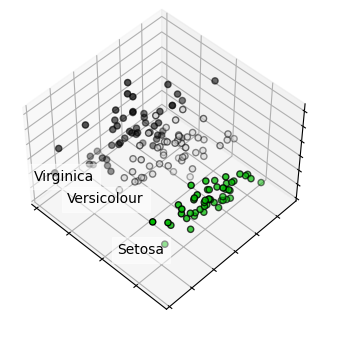

In [4]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])


plt.cla()

for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

## Projecting data: PCA vs. KernelPCA
In this section, we show the advantages of using a kernel when projecting data using a Principal Component Analysis (PCA). We create a dataset made of two nested circles.

In [5]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

Let’s have a quick first look at the generated dataset.

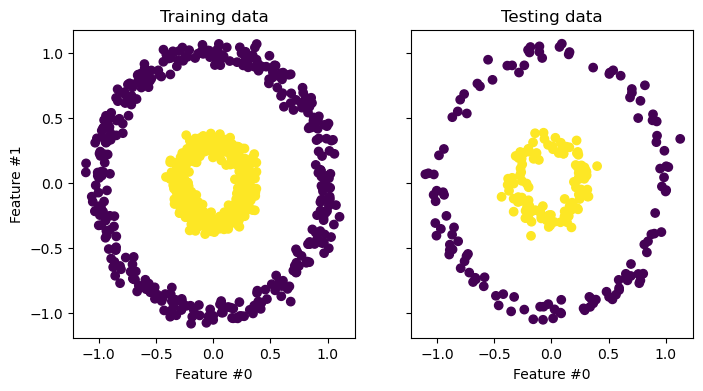

In [6]:

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

The samples from each class cannot be linearly separated: there is no straight line that can split the samples of the inner set from the outer set.

Now, we will use PCA with and without a kernel to see what is the effect of using such a kernel. The kernel used here is a radial basis function (RBF) kernel.

In [7]:
from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=2)
kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)

X_test_pca = pca.fit(X_train).transform(X_test)
X_test_kernel_pca = kernel_pca.fit(X_train).transform(X_test)

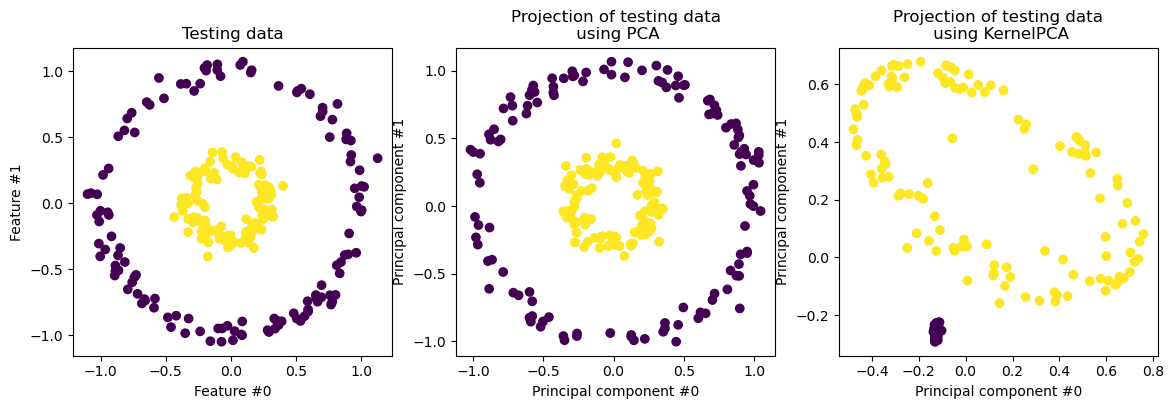

In [8]:
fig, (orig_data_ax, pca_proj_ax, kernel_pca_proj_ax) = plt.subplots(
    ncols=3, figsize=(14, 4)
)

orig_data_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("Testing data")

pca_proj_ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test)
pca_proj_ax.set_ylabel("Principal component #1")
pca_proj_ax.set_xlabel("Principal component #0")
pca_proj_ax.set_title("Projection of testing data\n using PCA")

kernel_pca_proj_ax.scatter(X_test_kernel_pca[:, 0], X_test_kernel_pca[:, 1], c=y_test)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")

We recall that PCA transforms the data linearly. Intuitively, it means that the coordinate system will be centered, rescaled on each component with respected to its variance and finally be rotated. The obtained data from this transformation is isotropic and can now be projected on its principal components.

Thus, looking at the projection made using PCA (i.e. the middle figure), we see that there is no change regarding the scaling; indeed the data being two concentric circles centered in zero, the original data is already isotropic. However, we can see that the data have been rotated. As a conclusion, we see that such a projection would not help if define a linear classifier to distinguish samples from both classes.

Using a kernel allows to make a non-linear projection. Here, by using an RBF kernel, we expect that the projection will unfold the dataset while keeping approximately preserving the relative distances of pairs of data points that are close to one another in the original space.

We observe such behaviour in the figure on the right: the samples of a given class are closer to each other than the samples from the opposite class, untangling both sample sets. Now, we can use a linear classifier to separate the samples from the two classes.

### Projecting into the original feature space
One particularity to have in mind when using KernelPCA is related to the reconstruction (i.e. the back projection in the original feature space). With PCA, the reconstruction will be exact if n_components is the same than the number of original features. This is the case in this example.

We can investigate if we get the original dataset when back projecting with KernelPCA.


In [9]:
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test))
X_reconstructed_kernel_pca = kernel_pca.inverse_transform(kernel_pca.transform(X_test))

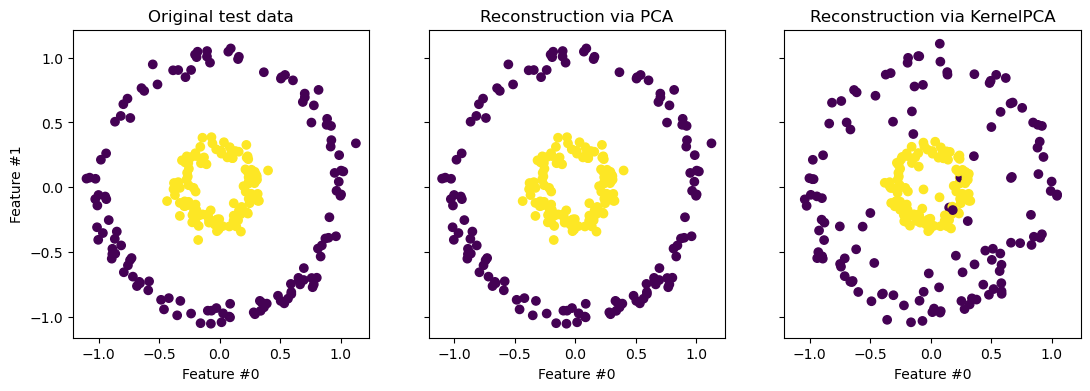

In [10]:
fig, (orig_data_ax, pca_back_proj_ax, kernel_pca_back_proj_ax) = plt.subplots(
    ncols=3, sharex=True, sharey=True, figsize=(13, 4)
)

orig_data_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("Original test data")

pca_back_proj_ax.scatter(X_reconstructed_pca[:, 0], X_reconstructed_pca[:, 1], c=y_test)
pca_back_proj_ax.set_xlabel("Feature #0")
pca_back_proj_ax.set_title("Reconstruction via PCA")

kernel_pca_back_proj_ax.scatter(
    X_reconstructed_kernel_pca[:, 0], X_reconstructed_kernel_pca[:, 1], c=y_test
)
kernel_pca_back_proj_ax.set_xlabel("Feature #0")
_ = kernel_pca_back_proj_ax.set_title("Reconstruction via KernelPCA")

While we see a perfect reconstruction with PCA we observe a different result for KernelPCA.

Indeed, inverse_transform cannot rely on an analytical back-projection and thus an exact reconstruction. Instead, a KernelRidge is internally trained to learn a mapping from the kernalized PCA basis to the original feature space. This method therefore comes with an approximation introducing small differences when back projecting in the original feature space.

To improve the reconstruction using inverse_transform, one can tune alpha in KernelPCA, the regularization term which controls the reliance on the training data during the training of the mapping.

### Practice:Image denoising using kernel PCA

The USPS digits datasets is available in OpenML. We use fetch_openml to get this dataset. In addition, we normalize the dataset such that all pixel values are in the range (0, 1).

In [11]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True)
X = MinMaxScaler().fit_transform(X)

/Users/bryce/anaconda3/envs/DSML/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


The idea will be to learn a PCA basis (with and without a kernel) on noisy images and then use these models to reconstruct and denoise these images.

Thus, we split our dataset into a training and testing set composed of 1,000 samples for the training and 100 samples for testing. These images are noise-free and we will use them to evaluate the efficiency of the denoising approaches. In addition, we create a copy of the original dataset and add a Gaussian noise.

The idea of this application, is to show that we can denoise corrupted images by learning a PCA basis on some uncorrupted images. We will use both a PCA and a kernel-based PCA to solve this problem.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, train_size=1_000, test_size=100
)

rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X_test.shape)
X_test_noisy = X_test + noise

noise = rng.normal(scale=0.25, size=X_train.shape)
X_train_noisy = X_train + noise

In addition, we will create a helper function to qualitatively assess the image reconstruction by plotting the test images.

In [13]:
import matplotlib.pyplot as plt


def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

In addition, we will use the mean squared error (MSE) to quantitatively assess the image reconstruction.

Let’s first have a look to see the difference between noise-free and noisy images. We will check the test set in this regard.

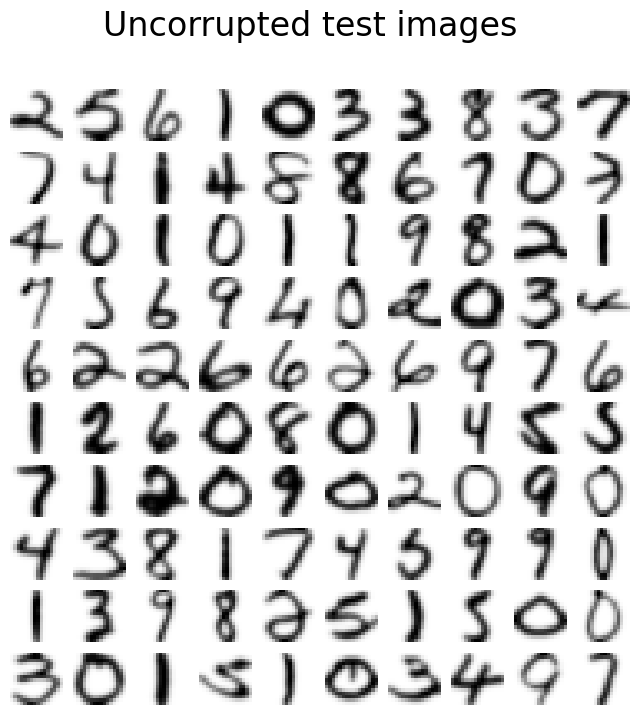

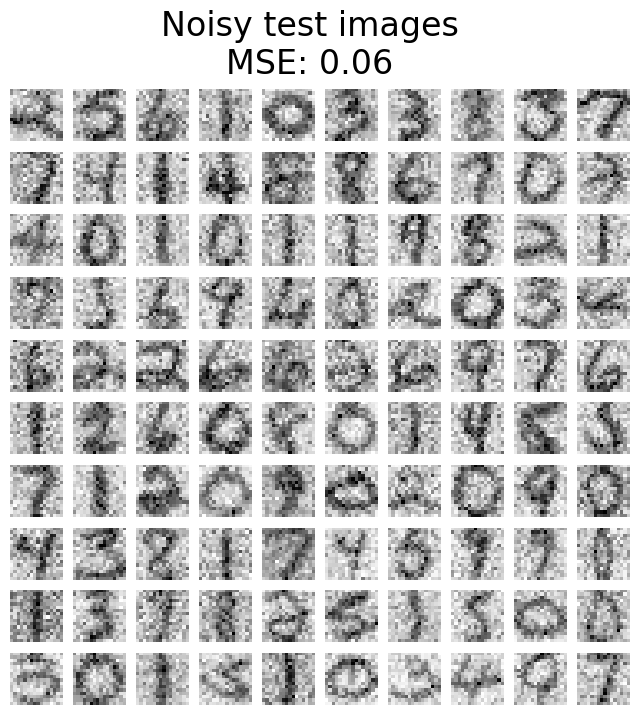

In [14]:
plot_digits(X_test, "Uncorrupted test images")
plot_digits(
    X_test_noisy, f"Noisy test images\nMSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}"
)

### PCA and Kernel PCA

We can now learn our PCA basis using both a linear PCA and a kernel PCA that uses a radial basis function (RBF) kernel.


In [15]:
from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=32, random_state=42)
kernel_pca = KernelPCA(
    n_components=400,
    kernel="rbf",
    gamma=1e-3,
    fit_inverse_transform=True,
    alpha=5e-3,
    random_state=42,
)

pca.fit(X_train_noisy)
_ = kernel_pca.fit(X_train_noisy)

### Reconstruct and denoise test images
Now, we can transform and reconstruct the noisy test set. Since we used less components than the number of original features, we will get an approximation of the original set. Indeed, by dropping the components explaining variance in PCA the least, we hope to remove noise. Similar thinking happens in kernel PCA; however, we expect a better reconstruction because we use a non-linear kernel to learn the PCA basis and a kernel ridge to learn the mapping function.

In [16]:
X_reconstructed_kernel_pca = kernel_pca.inverse_transform(
    kernel_pca.transform(X_test_noisy)
)
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))

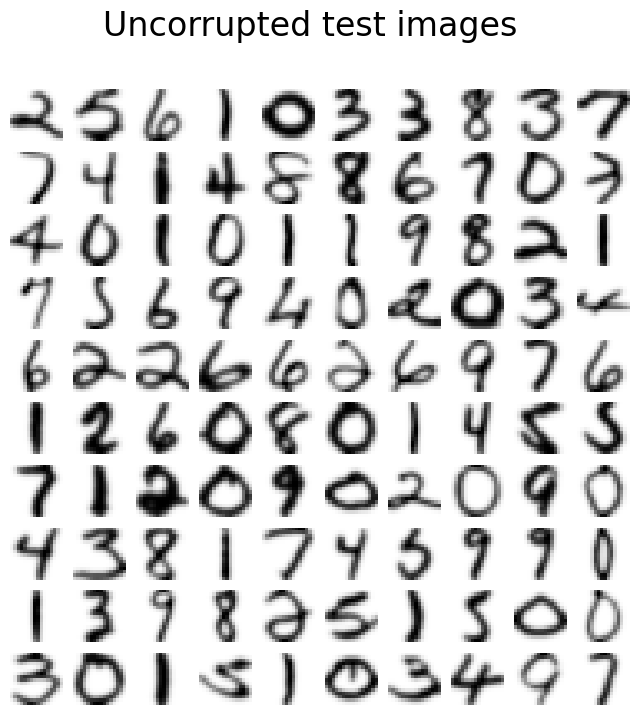

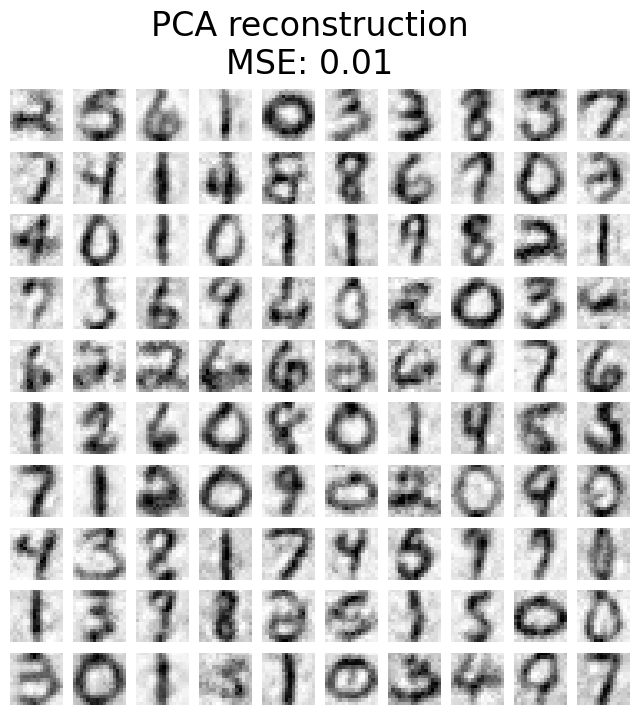

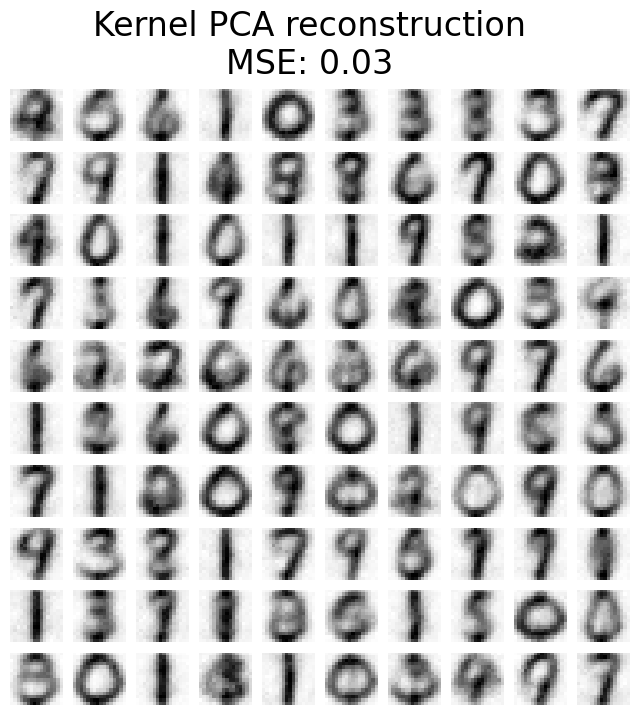

In [17]:
plot_digits(X_test, "Uncorrupted test images")
plot_digits(
    X_reconstructed_pca,
    f"PCA reconstruction\nMSE: {np.mean((X_test - X_reconstructed_pca) ** 2):.2f}",
)
plot_digits(
    X_reconstructed_kernel_pca,
    (
        "Kernel PCA reconstruction\n"
        f"MSE: {np.mean((X_test - X_reconstructed_kernel_pca) ** 2):.2f}"
    ),
)

PCA has a lower MSE than kernel PCA. However, the qualitative analysis might not favor PCA instead of kernel PCA. We observe that kernel PCA is able to remove background noise and provide a smoother image.

However, it should be noted that the results of the denoising with kernel PCA will depend of the parameters n_components, gamma, and alpha.

## Comparison of LDA and PCA 2D projection of Iris dataset

The Iris dataset represents 3 kind of Iris flowers (Setosa, Versicolour and Virginica) with 4 attributes: sepal length, sepal width, petal length and petal width.

Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data. Here we plot the different samples on the 2 first principal components.

Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.

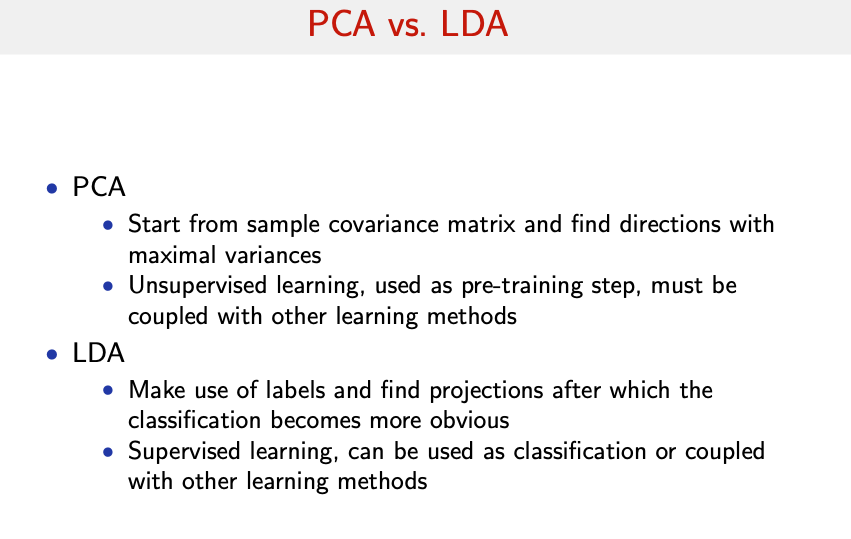

In [18]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

In [19]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)


explained variance ratio (first two components): [0.92461872 0.05306648]


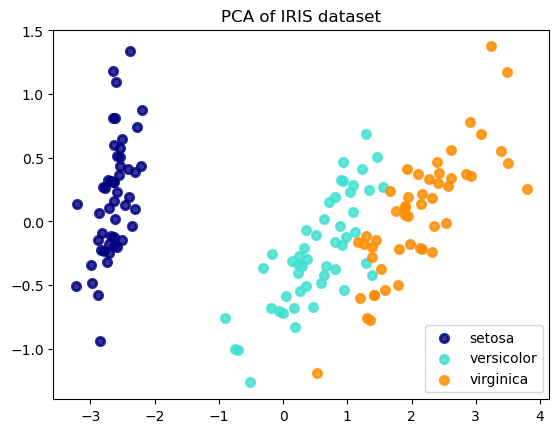

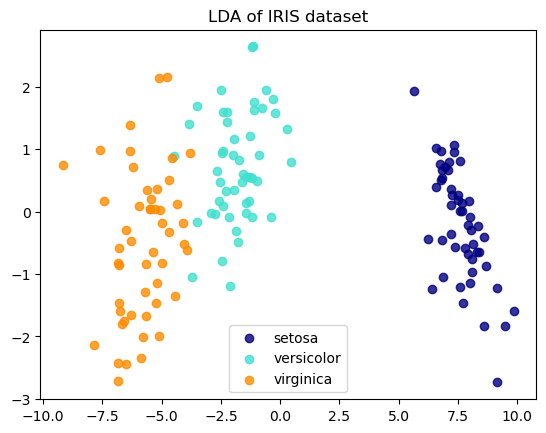

In [20]:
plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS dataset")

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of IRIS dataset")

plt.show()

## Comparison of Manifold Learning methods

An illustration of dimensionality reduction on the S-curve dataset with various manifold learning methods.

Note that the purpose of the MDS is to find a low-dimensional representation of the data (here 2D) in which the distances respect well the distances in the original high-dimensional space, unlike other manifold-learning algorithms, it does not seeks an isotropic representation of the data in the low-dimensional space.

### Dataset preparation

In [21]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker

from sklearn import datasets, manifold

n_samples = 1500
S_points, S_color = datasets.make_s_curve(n_samples, random_state=0)

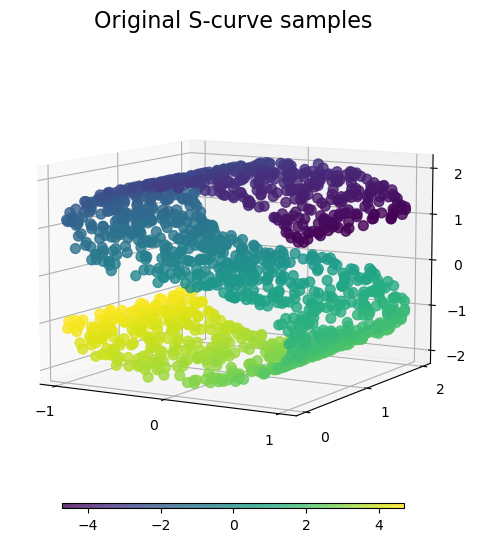

In [22]:
def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())


plot_3d(S_points, S_color, "Original S-curve samples")

### Define algorithms for the manifold learning
Manifold learning is an approach to non-linear dimensionality reduction. Algorithms for this task are based on the idea that the dimensionality of many data sets is only artificially high.

In [23]:
n_neighbors = 12  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

### Locally Linear Embeddings
Locally linear embedding (LLE) can be thought of as a series of local Principal Component Analyses which are globally compared to find the best non-linear embedding. 

In [24]:
params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "eigen_solver": "auto",
    "random_state": 0,
}

lle_standard = manifold.LocallyLinearEmbedding(method="standard", **params)
S_standard = lle_standard.fit_transform(S_points)

lle_ltsa = manifold.LocallyLinearEmbedding(method="ltsa", **params)
S_ltsa = lle_ltsa.fit_transform(S_points)

lle_hessian = manifold.LocallyLinearEmbedding(method="hessian", **params)
S_hessian = lle_hessian.fit_transform(S_points)

lle_mod = manifold.LocallyLinearEmbedding(method="modified", **params)
S_mod = lle_mod.fit_transform(S_points)

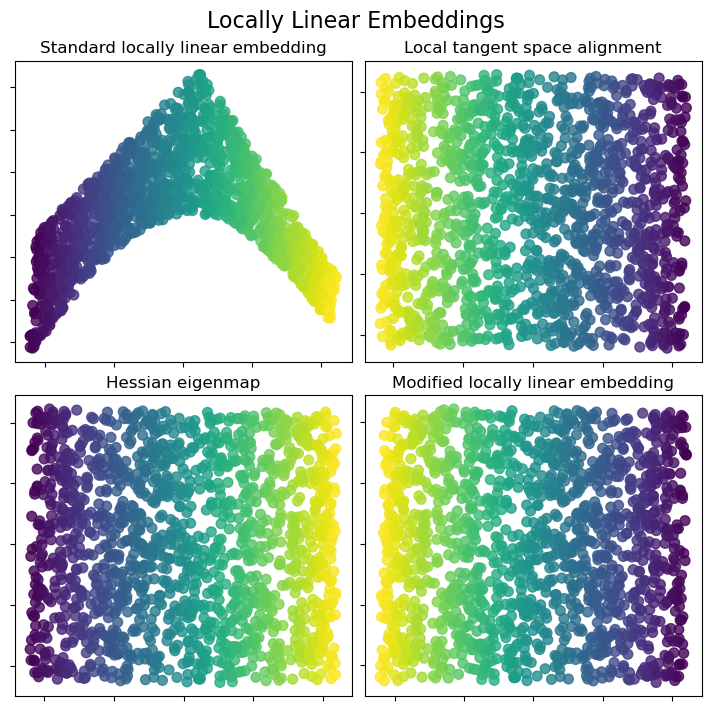

In [25]:
fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(7, 7), facecolor="white", constrained_layout=True
)
fig.suptitle("Locally Linear Embeddings", size=16)

lle_methods = [
    ("Standard locally linear embedding", S_standard),
    ("Local tangent space alignment", S_ltsa),
    ("Hessian eigenmap", S_hessian),
    ("Modified locally linear embedding", S_mod),
]
for ax, method in zip(axs.flat, lle_methods):
    name, points = method
    add_2d_scatter(ax, points, S_color, name)

plt.show()

### Isomap Embedding
Non-linear dimensionality reduction through Isometric Mapping. Isomap seeks a lower-dimensional embedding which maintains geodesic distances between all points.

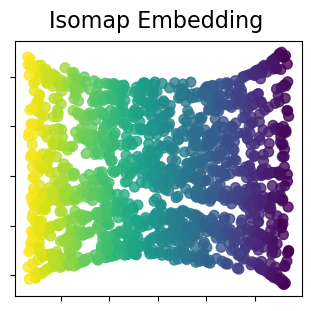

In [26]:
isomap = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components, p=1)
S_isomap = isomap.fit_transform(S_points)

plot_2d(S_isomap, S_color, "Isomap Embedding")

### Multidimensional scaling

Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.

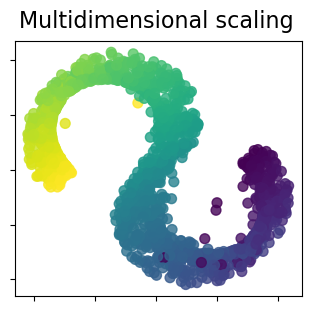

In [27]:
md_scaling = manifold.MDS(
    n_components=n_components,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
)
S_scaling = md_scaling.fit_transform(S_points)

plot_2d(S_scaling, S_color, "Multidimensional scaling")

### Spectral embedding for non-linear dimensionality reduction
This implementation uses Laplacian Eigenmaps, which finds a low dimensional representation of the data using a spectral decomposition of the graph Laplacian. 

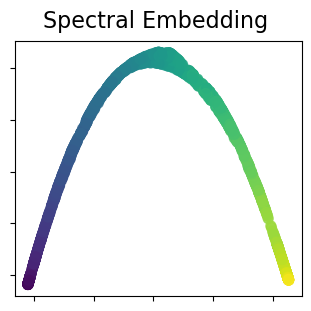

In [28]:
spectral = manifold.SpectralEmbedding(
    n_components=n_components, n_neighbors=n_neighbors, random_state=42
)
S_spectral = spectral.fit_transform(S_points)

plot_2d(S_spectral, S_color, "Spectral Embedding")

### T-distributed Stochastic Neighbor Embedding
It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

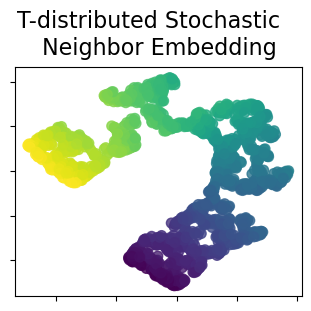

In [30]:
t_sne = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="random",
    random_state=0,
)
S_t_sne = t_sne.fit_transform(S_points)

plot_2d(S_t_sne, S_color, "T-distributed Stochastic  \n Neighbor Embedding")